### IMDB Subwords - Single layer BiLSTM

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
import pandas as pd
import numpy as np
import csv
import random
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete4D7UAG/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete4D7UAG/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete4D7UAG/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [ ]:
dataset

{'test': <PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>,
 'train': <PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>,
 'unsupervised': <PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>}

In [ ]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Pot

In [ ]:
train_data, test_data = dataset['train'], dataset['test']

In [ ]:
tokenizer = info.features['text'].encoder

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_data = train_data.shuffle(BUFFER_SIZE)
train_data = train_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_data))
test_data = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))

In [ ]:
embedding_dim = 64
num_classes = 1

In [ ]:
model = Sequential([
    layers.Embedding(input_dim=tokenizer.vocab_size, output_dim=embedding_dim),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer   = tf.keras.optimizers.Adam(learning_rate=0.01)
loss        = tf.keras.losses.BinaryCrossentropy()
metrics     = ['accuracy']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
early_stopping    = EarlyStopping(monitor='loss', patience=7)
reduce_lr         = ReduceLROnPlateau(monitor='loss', patience=7, min_lr=0.001, mode='min', verbose=1)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
epochs = 15
callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
history = model.fit(train_data,
                    validation_data=test_data,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/15
391/391 [==============================] - 169s 409ms/step - loss: 0.5946 - accuracy: 0.6730 - val_loss: 0.4021 - val_accuracy: 0.8374
Epoch 2/15
391/391 [==============================] - 157s 400ms/step - loss: 0.3297 - accuracy: 0.8636 - val_loss: 0.3932 - val_accuracy: 0.8224
Epoch 3/15
391/391 [==============================] - 158s 401ms/step - loss: 0.2628 - accuracy: 0.8973 - val_loss: 0.3545 - val_accuracy: 0.8552
Epoch 4/15
391/391 [==============================] - 157s 400ms/step - loss: 0.2399 - accuracy: 0.9075 - val_loss: 0.3746 - val_accuracy: 0.8654
Epoch 5/15
391/391 [==============================] - 159s 405ms/step - loss: 0.2004 - accuracy: 0.9242 - val_loss: 0.4240 - val_accuracy: 0.8502
Epoch 6/15
391/391 [==============================] - 159s 404ms/step - loss: 0.1820 - accuracy: 0.9311 - val_loss: 0.3764 - val_accuracy: 0.8514
Epoch 7/15
391/391 [==============================] - 160s 406ms/step - loss: 0.1507 - accuracy: 0.9449 - val_loss: 0.4750 -

<Figure size 432x288 with 0 Axes>

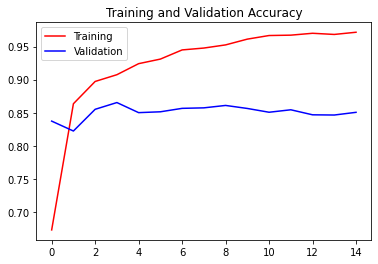

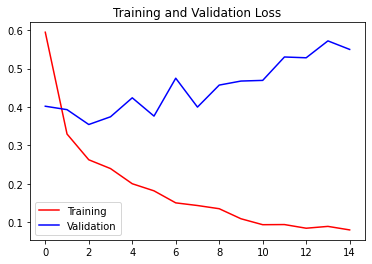

<Figure size 432x288 with 0 Axes>

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

### IMDB Subwords - Multi layer BiLSTM

In [ ]:
embedding_dim = 64
num_classes = 1

In [ ]:
model = Sequential([
    layers.Embedding(input_dim=tokenizer.vocab_size, output_dim=embedding_dim),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 635,329
Trainable params: 635,329
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer   = tf.keras.optimizers.Adam(learning_rate=0.01)
loss        = tf.keras.losses.BinaryCrossentropy()
metrics     = ['accuracy']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
early_stopping    = EarlyStopping(monitor='loss', patience=5)
reduce_lr         = ReduceLROnPlateau(monitor='loss', patience=5, min_lr=0.001, mode='min', verbose=1)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
epochs = 15
callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
history = model.fit(train_data,
                    validation_data=test_data,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/15
391/391 [==============================] - 321s 801ms/step - loss: 0.5923 - accuracy: 0.6816 - val_loss: 0.4894 - val_accuracy: 0.7767
Epoch 2/15
391/391 [==============================] - 308s 787ms/step - loss: 0.3596 - accuracy: 0.8472 - val_loss: 0.3243 - val_accuracy: 0.8651
Epoch 3/15
391/391 [==============================] - 307s 785ms/step - loss: 0.2566 - accuracy: 0.8983 - val_loss: 0.3280 - val_accuracy: 0.8607
Epoch 4/15
391/391 [==============================] - 307s 784ms/step - loss: 0.2039 - accuracy: 0.9225 - val_loss: 0.3251 - val_accuracy: 0.8744
Epoch 5/15
391/391 [==============================] - 309s 789ms/step - loss: 0.1568 - accuracy: 0.9436 - val_loss: 0.3316 - val_accuracy: 0.8719
Epoch 6/15
391/391 [==============================] - 312s 795ms/step - loss: 0.1262 - accuracy: 0.9556 - val_loss: 0.3535 - val_accuracy: 0.8662
Epoch 7/15
391/391 [==============================] - 309s 788ms/step - loss: 0.0936 - accuracy: 0.9683 - val_loss: 0.4015 -

<Figure size 432x288 with 0 Axes>

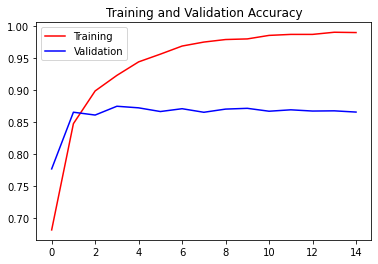

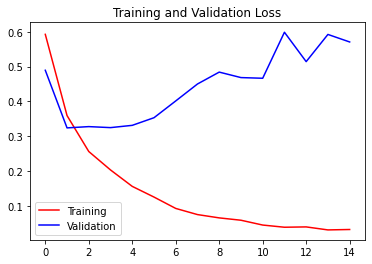

<Figure size 432x288 with 0 Axes>

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

### IMDB Subwords - Conv1D

In [ ]:
embedding_dim = 64
num_classes = 1

In [ ]:
model = Sequential([
    layers.Embedding(input_dim=tokenizer.vocab_size, output_dim=embedding_dim),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         41088     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 573,249
Trainable params: 573,249
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer   = tf.keras.optimizers.Adam(learning_rate=0.01)
loss        = tf.keras.losses.BinaryCrossentropy()
metrics     = ['accuracy']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
early_stopping    = EarlyStopping(monitor='loss', patience=5)
reduce_lr         = ReduceLROnPlateau(monitor='loss', patience=5, min_lr=0.001, mode='min', verbose=1)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
epochs = 15
callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
history = model.fit(train_data,
                    validation_data=test_data,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/15
391/391 [==============================] - 74s 121ms/step - loss: 0.3566 - accuracy: 0.8381 - val_loss: 0.2683 - val_accuracy: 0.8897
Epoch 2/15
391/391 [==============================] - 24s 59ms/step - loss: 0.1901 - accuracy: 0.9292 - val_loss: 0.3010 - val_accuracy: 0.8811
Epoch 3/15
391/391 [==============================] - 20s 50ms/step - loss: 0.1353 - accuracy: 0.9504 - val_loss: 0.3995 - val_accuracy: 0.8551
Epoch 4/15
391/391 [==============================] - 18s 44ms/step - loss: 0.0970 - accuracy: 0.9644 - val_loss: 0.4295 - val_accuracy: 0.8677
Epoch 5/15
391/391 [==============================] - 18s 43ms/step - loss: 0.0644 - accuracy: 0.9780 - val_loss: 0.4879 - val_accuracy: 0.8657
Epoch 6/15
391/391 [==============================] - 17s 42ms/step - loss: 0.0452 - accuracy: 0.9840 - val_loss: 0.6129 - val_accuracy: 0.8600
Epoch 7/15
391/391 [==============================] - 17s 41ms/step - loss: 0.0390 - accuracy: 0.9870 - val_loss: 0.7659 - val_accuracy

<Figure size 432x288 with 0 Axes>

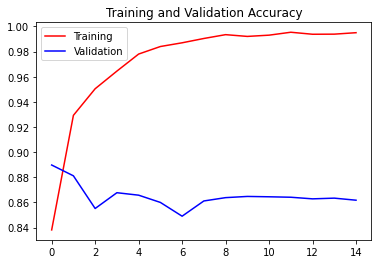

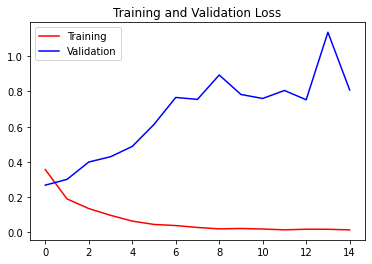

<Figure size 432x288 with 0 Axes>

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

## IMDB - BiLSTM

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
import pandas as pd
import numpy as np
import csv
import random
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import tensorflow_datasets as tfds

imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

In [ ]:
imdb

{'test': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 'train': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 'unsupervised': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>}

In [ ]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

In [ ]:
train_data, test_data = imdb['train'], imdb['test']

In [ ]:
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s, l in train_data:
  training_sentences.append(str(s.numpy()))         # tensor -> numpy -> extracting sentences 
  training_labels.append(l.numpy())                 # tensor -> numpy -> extracting labels
  
for s, l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())

In [ ]:
training_sentences[:2]

['b"This was an absolutely terrible movie. Don\'t be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie\'s ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor\'s like Christopher Walken\'s good name. I could barely sit through it."',
 "b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot devel

In [ ]:
training_labels[:2]

[0, 0]

In [ ]:
len(training_sentences), len(training_labels)

(25000, 25000)

In [ ]:
len(testing_sentences), len(testing_labels)

(25000, 25000)

In [ ]:
type(training_labels)

list

In [ ]:
# when training, labels should be numpy arrays

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [ ]:
vocab_size = 10000                      # number of unique words in the corpus
embedding_dim = 16                      # number of dimensions we wish to embed each word into
max_length = 120                        # maximum length of document/sentence

trunc_type = "post"                     
oov_tok = "<OOV>"                       # out of vocab words in test set will be marked OOV

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [ ]:
len(word_index)

86539

In [ ]:
num_classes = 1

In [ ]:
model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(6, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer   = tf.keras.optimizers.Adam(learning_rate=0.01)
loss        = tf.keras.losses.BinaryCrossentropy()
metrics     = ['accuracy']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
early_stopping    = EarlyStopping(monitor='loss', patience=7)
reduce_lr         = ReduceLROnPlateau(monitor='loss', patience=7, min_lr=0.001, mode='min', verbose=1)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
epochs = 20
callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
history = model.fit(training_padded,
                    training_labels,
                    validation_data=(testing_padded, testing_labels),
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/20
782/782 [==============================] - 54s 58ms/step - loss: 0.5293 - accuracy: 0.7250 - val_loss: 0.3734 - val_accuracy: 0.8336
Epoch 2/20
782/782 [==============================] - 45s 58ms/step - loss: 0.3038 - accuracy: 0.8736 - val_loss: 0.3962 - val_accuracy: 0.8328
Epoch 3/20
782/782 [==============================] - 45s 58ms/step - loss: 0.2188 - accuracy: 0.9138 - val_loss: 0.3997 - val_accuracy: 0.8256
Epoch 4/20
782/782 [==============================] - 45s 57ms/step - loss: 0.1446 - accuracy: 0.9462 - val_loss: 0.4622 - val_accuracy: 0.8318
Epoch 5/20
782/782 [==============================] - 45s 57ms/step - loss: 0.0921 - accuracy: 0.9681 - val_loss: 0.5394 - val_accuracy: 0.8188
Epoch 6/20
782/782 [==============================] - 45s 57ms/step - loss: 0.0677 - accuracy: 0.9760 - val_loss: 0.6414 - val_accuracy: 0.8292
Epoch 7/20
782/782 [==============================] - 45s 58ms/step - loss: 0.0490 - accuracy: 0.9835 - val_loss: 0.7027 - val_accuracy:

<Figure size 432x288 with 0 Axes>

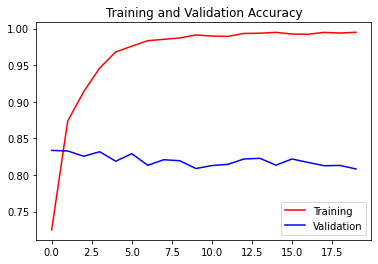

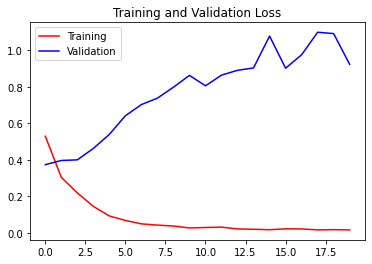

<Figure size 432x288 with 0 Axes>

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

## IMDB - BiGRU

In [ ]:
num_classes = 1

In [ ]:
model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    layers.Bidirectional(layers.GRU(32)),
    layers.Dense(6, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                9600      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer   = tf.keras.optimizers.Adam(learning_rate=0.01)
loss        = tf.keras.losses.BinaryCrossentropy()
metrics     = ['accuracy']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
early_stopping    = EarlyStopping(monitor='loss', patience=7)
reduce_lr         = ReduceLROnPlateau(monitor='loss', patience=7, min_lr=0.001, mode='min', verbose=1)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
epochs = 20
callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
history = model.fit(training_padded,
                    training_labels,
                    validation_data=(testing_padded, testing_labels),
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

# loss was stuck so had to run model part 3 times

Epoch 1/20
782/782 [==============================] - 50s 59ms/step - loss: 0.4434 - accuracy: 0.7773 - val_loss: 0.3194 - val_accuracy: 0.8624
Epoch 2/20
782/782 [==============================] - 45s 58ms/step - loss: 0.2490 - accuracy: 0.9019 - val_loss: 0.3443 - val_accuracy: 0.8549
Epoch 3/20
782/782 [==============================] - 45s 58ms/step - loss: 0.1549 - accuracy: 0.9433 - val_loss: 0.4513 - val_accuracy: 0.8288
Epoch 4/20
782/782 [==============================] - 45s 58ms/step - loss: 0.1018 - accuracy: 0.9620 - val_loss: 0.5348 - val_accuracy: 0.8269
Epoch 5/20
782/782 [==============================] - 45s 58ms/step - loss: 0.0700 - accuracy: 0.9748 - val_loss: 0.5087 - val_accuracy: 0.8333
Epoch 6/20
782/782 [==============================] - 45s 58ms/step - loss: 0.0577 - accuracy: 0.9798 - val_loss: 0.6960 - val_accuracy: 0.8223
Epoch 7/20
782/782 [==============================] - 45s 58ms/step - loss: 0.0473 - accuracy: 0.9833 - val_loss: 0.8136 - val_accuracy:

<Figure size 432x288 with 0 Axes>

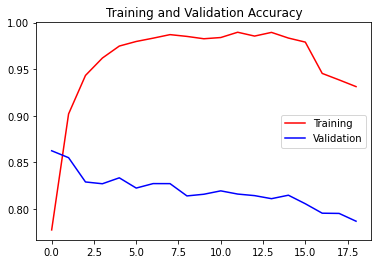

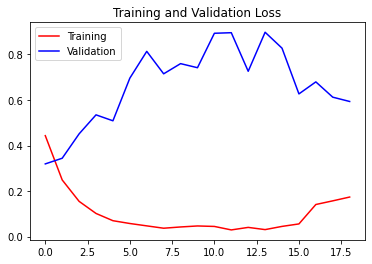

<Figure size 432x288 with 0 Axes>

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

## IMDB - Conv1D

In [ ]:
num_classes = 1

In [ ]:
model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(6, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer   = tf.keras.optimizers.Adam(learning_rate=0.01)
loss        = tf.keras.losses.BinaryCrossentropy()
metrics     = ['accuracy']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
early_stopping    = EarlyStopping(monitor='loss', patience=7)
reduce_lr         = ReduceLROnPlateau(monitor='loss', patience=7, min_lr=0.001, mode='min', verbose=1)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
epochs = 20
callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
history = model.fit(training_padded,
                    training_labels,
                    validation_data=(testing_padded, testing_labels),
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/20
782/782 [==============================] - 33s 9ms/step - loss: 0.4071 - accuracy: 0.8122 - val_loss: 0.3681 - val_accuracy: 0.8344
Epoch 2/20
782/782 [==============================] - 6s 8ms/step - loss: 0.2588 - accuracy: 0.8968 - val_loss: 0.3715 - val_accuracy: 0.8424
Epoch 3/20
782/782 [==============================] - 7s 9ms/step - loss: 0.1928 - accuracy: 0.9249 - val_loss: 0.3984 - val_accuracy: 0.8304
Epoch 4/20
782/782 [==============================] - 6s 8ms/step - loss: 0.1338 - accuracy: 0.9515 - val_loss: 0.4879 - val_accuracy: 0.8244
Epoch 5/20
782/782 [==============================] - 6s 8ms/step - loss: 0.0922 - accuracy: 0.9672 - val_loss: 0.6453 - val_accuracy: 0.8212
Epoch 6/20
782/782 [==============================] - 6s 8ms/step - loss: 0.0652 - accuracy: 0.9760 - val_loss: 0.7276 - val_accuracy: 0.8135
Epoch 7/20
782/782 [==============================] - 6s 8ms/step - loss: 0.0431 - accuracy: 0.9850 - val_loss: 0.9439 - val_accuracy: 0.8081
Epoch

<Figure size 432x288 with 0 Axes>

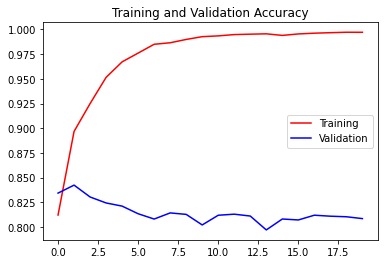

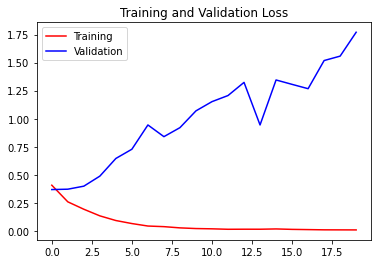

<Figure size 432x288 with 0 Axes>

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

## Sarcasm - BiLSTM

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /content/sarcasm.json

--2021-08-06 06:49:40--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 74.125.137.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/content/sarcasm.json’

/content/sarcasm.js 100%[===================>]   5.38M  --.-KB/s    in 0.02s   

2021-08-06 06:49:40 (240 MB/s) - ‘/content/sarcasm.json’ saved [5643545/5643545]



In [ ]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [ ]:
with open("/content/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [ ]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_14 (Dense)             (None, 24)                1560      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 25        
Total params: 30,129
Trainable params: 30,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 20
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)

Epoch 1/20
625/625 [==============================] - 11s 14ms/step - loss: 0.4532 - accuracy: 0.7671 - val_loss: 0.3905 - val_accuracy: 0.8208
Epoch 2/20
625/625 [==============================] - 7s 12ms/step - loss: 0.3530 - accuracy: 0.8374 - val_loss: 0.3799 - val_accuracy: 0.8271
Epoch 3/20
625/625 [==============================] - 7s 12ms/step - loss: 0.3291 - accuracy: 0.8499 - val_loss: 0.3837 - val_accuracy: 0.8208
Epoch 4/20
625/625 [==============================] - 7s 12ms/step - loss: 0.3131 - accuracy: 0.8599 - val_loss: 0.3742 - val_accuracy: 0.8311
Epoch 5/20
625/625 [==============================] - 7s 12ms/step - loss: 0.3040 - accuracy: 0.8648 - val_loss: 0.3736 - val_accuracy: 0.8319
Epoch 6/20
625/625 [==============================] - 7s 12ms/step - loss: 0.2958 - accuracy: 0.8668 - val_loss: 0.3766 - val_accuracy: 0.8319
Epoch 7/20
625/625 [==============================] - 8s 12ms/step - loss: 0.2886 - accuracy: 0.8732 - val_loss: 0.3720 - val_accuracy: 0.832

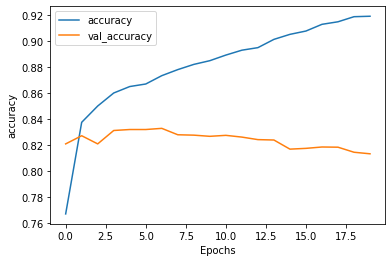

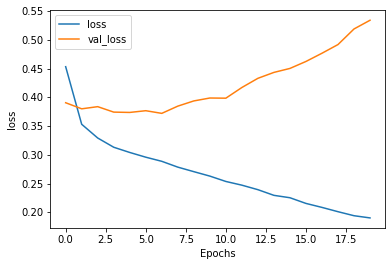

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

## Sarcasm - Conv1D

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 116, 128)          10368     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 24)                3096      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 25        
Total params: 29,489
Trainable params: 29,489
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 20
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)

Epoch 1/20
625/625 [==============================] - 3s 4ms/step - loss: 0.4706 - accuracy: 0.7619 - val_loss: 0.4115 - val_accuracy: 0.8140
Epoch 2/20
625/625 [==============================] - 3s 4ms/step - loss: 0.3603 - accuracy: 0.8383 - val_loss: 0.3916 - val_accuracy: 0.8277
Epoch 3/20
625/625 [==============================] - 3s 4ms/step - loss: 0.3206 - accuracy: 0.8594 - val_loss: 0.3942 - val_accuracy: 0.8278
Epoch 4/20
625/625 [==============================] - 2s 4ms/step - loss: 0.2889 - accuracy: 0.8752 - val_loss: 0.4012 - val_accuracy: 0.8268
Epoch 5/20
625/625 [==============================] - 2s 4ms/step - loss: 0.2569 - accuracy: 0.8914 - val_loss: 0.4195 - val_accuracy: 0.8204
Epoch 6/20
625/625 [==============================] - 2s 4ms/step - loss: 0.2253 - accuracy: 0.9089 - val_loss: 0.4549 - val_accuracy: 0.8201
Epoch 7/20
625/625 [==============================] - 2s 4ms/step - loss: 0.1926 - accuracy: 0.9244 - val_loss: 0.4923 - val_accuracy: 0.8146
Epoch 

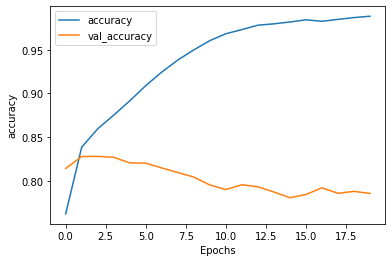

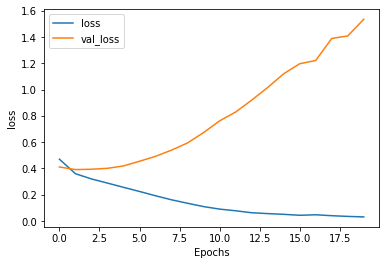

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

## Exercise 11

Running on Stanford dataset.

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /content/training_cleaned.csv

--2021-08-06 07:00:54--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.101.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/content/training_cleaned.csv’

/content/training_c 100%[===================>] 227.87M   157MB/s    in 1.5s    

2021-08-06 07:00:56 (157 MB/s) - ‘/content/training_cleaned.csv’ saved [238942690/238942690]



In [ ]:
num_sentences = 0
corpus = []

with open("/content/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        list_item.append(row[5])
        this_label=row[0]
        if this_label=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)

In [ ]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [ ]:
embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000
test_portion=.1

In [ ]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [ ]:
print(vocab_size)
print(word_index['i'])

137960
1


In [ ]:
# getting Glove

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /content/glove.6B.100d.txt

--2021-08-06 07:04:29--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 74.125.137.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-08-06 07:04:29 ERROR 404: Not Found.



In [ ]:
embeddings_index = {};
with open('/content/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [ ]:
print(len(embeddings_matrix))

137961


In [ ]:
training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 16, 100)           13796100  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 13,861,253
Trainable params: 65,153
Non-trainable params: 13,796,100
_____________________________________

In [ ]:
num_epochs = 20
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/20
4500/4500 - 14s - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6932 - val_accuracy: 0.4964
Epoch 2/20
4500/4500 - 13s - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6932 - val_accuracy: 0.4964
Epoch 3/20
4500/4500 - 14s - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.4964
Epoch 4/20
4500/4500 - 14s - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.5036
Epoch 5/20
4500/4500 - 13s - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6931 - val_accuracy: 0.5036
Epoch 6/20
4500/4500 - 13s - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.4964
Epoch 7/20
4500/4500 - 13s - loss: 0.6932 - accuracy: 0.4979 - val_loss: 0.6931 - val_accuracy: 0.5036
Epoch 8/20
4500/4500 - 14s - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6932 - val_accuracy: 0.4964
Epoch 9/20
4500/4500 - 13s - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6931 - val_accuracy: 0.4964
Epoch 10/20
4500/4500 - 13s - loss: 0.6932 - accuracy: 0.4996 - val_loss:

<Figure size 432x288 with 0 Axes>

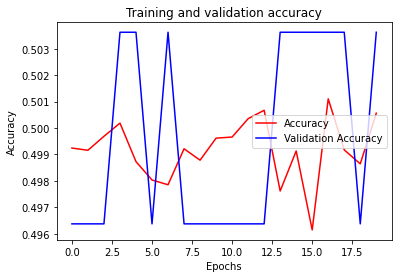

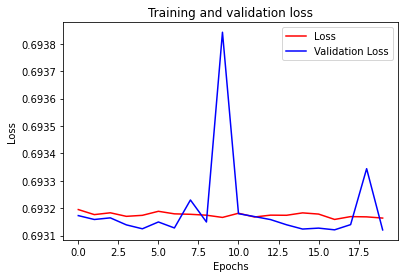

<Figure size 432x288 with 0 Axes>

In [ ]:

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()